# Electricity Forecasting - FB Prophet

用 Prophet 來預測被轉容量
https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from prophet import Prophet
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

/opt/anaconda3/envs/python3_8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 參數設定

In [2]:
n_tests = 15 # numbers of days reserved for testing
start_offset_first = 0
start_offset_second = 0
start_offset_final = 0
# dependencies = ['op_reserve_ratio']
# dependencies = ['peak_supply']
dependencies = ['peak_supply', 'op_reserve_ratio']
first_forecast = 'peak_supply'
second_forecast = 'op_reserve_ratio'
regressors_first = ['is_holiday', 'month', 'year', 'day']
if first_forecast in dependencies:
    regressors_second = [first_forecast, 'is_holiday', 'month', 'year', 'day']
else:
    regressors_second = ['is_holiday', 'month', 'year', 'day']
regressors_op_reserve = dependencies + ['is_holiday', 'day_of_week', 'month']
print(regressors_op_reserve)

['peak_supply', 'op_reserve_ratio', 'is_holiday', 'day_of_week', 'month']


## Data Collation / Wrangling

In [3]:
'''
load data
'''
raw_data = []
raw_data = pd.DataFrame(raw_data)

holiday_data = []
holiday_data = pd.DataFrame(holiday_data)

file = '台灣電力公司_過去電力供需資訊2017.csv'
raw_data_new = pd.read_csv(file)
raw_data_new = pd.DataFrame(raw_data_new)
raw_data_new = raw_data_new.loc[:,['日期','備轉容量(MW)', '備轉容量率(%)']]
raw_data_new.columns=['date','op_reserve', 'op_reserve_ratio']
for idx, date in enumerate(raw_data_new['date']):
    raw_data_new['op_reserve'][idx] /= 10
    date = str(raw_data_new['date'][idx])
    raw_data_new['date'][idx] = date[:2] + '/'.join(date[i:i+2] for i in range(2, len(date), 2))
raw_data_new['date']= pd.to_datetime(raw_data_new['date'])
raw_data_new['year']= pd.DatetimeIndex(raw_data_new['date']).year
raw_data_new['month']= pd.DatetimeIndex(raw_data_new['date']).month
raw_data_new['day']= pd.DatetimeIndex(raw_data_new['date']).day
raw_data_new['day_of_week'] = raw_data_new['date'].dt.dayofweek
raw_data = pd.concat([raw_data, raw_data_new])

file = '台灣電力公司_過去電力供需資訊2018.csv'
raw_data_new = pd.read_csv(file)
raw_data_new = pd.DataFrame(raw_data_new)
raw_data_new = raw_data_new.loc[:,['日期','備轉容量(MW)', '備轉容量率(%)']]
raw_data_new.columns=['date','op_reserve', 'op_reserve_ratio']
for idx, date in enumerate(raw_data_new['date']):
    raw_data_new['op_reserve'][idx] /= 10
    date = str(raw_data_new['date'][idx])
    raw_data_new['date'][idx] = date[:2] + '/'.join(date[i:i+2] for i in range(2, len(date), 2))
raw_data_new['date']= pd.to_datetime(raw_data_new['date'])
raw_data_new['year']= pd.DatetimeIndex(raw_data_new['date']).year
raw_data_new['month']= pd.DatetimeIndex(raw_data_new['date']).month
raw_data_new['day']= pd.DatetimeIndex(raw_data_new['date']).day
raw_data_new['day_of_week'] = raw_data_new['date'].dt.dayofweek
raw_data = pd.concat([raw_data, raw_data_new])

file = '近三年每日尖峰備轉容量率2019-2021.csv'
raw_data_new = pd.read_csv(file)
raw_data_new = pd.DataFrame(raw_data_new)
raw_data_new = raw_data_new.loc[:,['日期','備轉容量(萬瓩)', '備轉容量率(%)']]
raw_data_new.columns=['date','op_reserve', 'op_reserve_ratio']
raw_data_new['date']= pd.to_datetime(raw_data_new['date'])
raw_data_new['year']= pd.DatetimeIndex(raw_data_new['date']).year
raw_data_new['month']= pd.DatetimeIndex(raw_data_new['date']).month
raw_data_new['day']= pd.DatetimeIndex(raw_data_new['date']).day
raw_data_new['day_of_week'] = raw_data_new['date'].dt.dayofweek
raw_data = pd.concat([raw_data, raw_data_new])

file =  '台灣電力公司_本年度每日尖峰備轉容量率2022.csv'
raw_data_new = pd.read_csv(file)
raw_data_new = pd.DataFrame(raw_data_new)
raw_data_new = raw_data_new.loc[:,[True,True,True]]
raw_data_new.columns = ['date', 'op_reserve', 'op_reserve_ratio']
raw_data_new['date'] = pd.to_datetime(raw_data_new['date'])
raw_data_new['year']= pd.DatetimeIndex(raw_data_new['date']).year
raw_data_new['month']= pd.DatetimeIndex(raw_data_new['date']).month
raw_data_new['day']= pd.DatetimeIndex(raw_data_new['date']).day
raw_data_new['day_of_week'] = raw_data_new['date'].dt.dayofweek
raw_data = pd.concat([raw_data,raw_data_new])

for file in ['106年政府機關辦公日曆表.csv',
             '107政府機關辦公日曆表(數字版).csv',
             '108年中華民國政府行政機關辦公日曆表.csv',
             '109年中華民國政府行政機關辦公日曆表.csv',
             '110中華民國政府行政機關辦公日曆表.csv',
             '111年中華民國政府行政機關辦公日曆表.csv']:
    raw_data_new = pd.read_csv(file)
    raw_data_new = pd.DataFrame(raw_data_new)
    raw_data_new = raw_data_new.loc[:,[True, False, True, False]]
    raw_data_new.columns=['date','is_holiday']
    for idx, date in enumerate(raw_data_new['date']):
        date = str(raw_data_new['date'][idx])
        raw_data_new['date'][idx] = date[:2] + '/'.join(date[i:i+2] for i in range(2, len(date), 2))
    raw_data_new['date']= pd.to_datetime(raw_data_new['date'])
    raw_data_new['year']= pd.DatetimeIndex(raw_data_new['date']).year
    raw_data_new['month']= pd.DatetimeIndex(raw_data_new['date']).month
    raw_data_new['day']= pd.DatetimeIndex(raw_data_new['date']).day
    raw_data_new['day_of_week'] = raw_data_new['date'].dt.dayofweek
    holiday_data = pd.concat([holiday_data, raw_data_new])

raw_data = holiday_data.merge(raw_data)

'''
Trim outliers & convert unit
'''
# FIXME: use difference instead?
op_reserve_mean = round(float(raw_data['op_reserve'].mean()), 1)
raw_data['peak_supply'] = raw_data['op_reserve_ratio'].values
for i, op_reserve in enumerate(raw_data['op_reserve']):
    raw_data['op_reserve'][i] = raw_data['op_reserve'][i] * 10
    raw_data['peak_supply'][i] = raw_data['op_reserve'][i] * 100 / raw_data['op_reserve_ratio'][i]
    
'''
split training set and testing set
'''
train = raw_data[start_offset_first:-n_tests]
test = raw_data[-n_tests:]

<AxesSubplot:xlabel='date'>

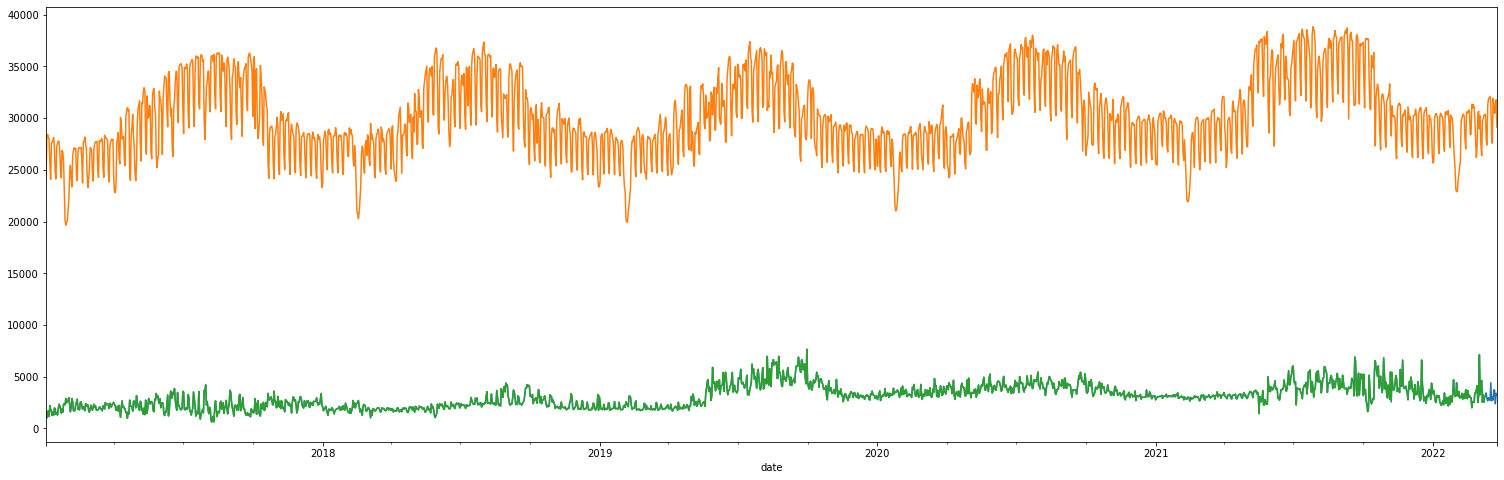

In [4]:
raw_data_tmp = raw_data[:]
raw_data_tmp.set_index('date',inplace=True)
raw_data_tmp['op_reserve'].plot(label='first_data', figsize=(26,8))
raw_data_tmp['peak_supply'].plot(label='first_data', figsize=(26,8))

train_tmp = train[:]
train_tmp.set_index('date',inplace=True)
train_tmp['op_reserve'].plot(label='first_data', figsize=(26,8))

<AxesSubplot:xlabel='date'>

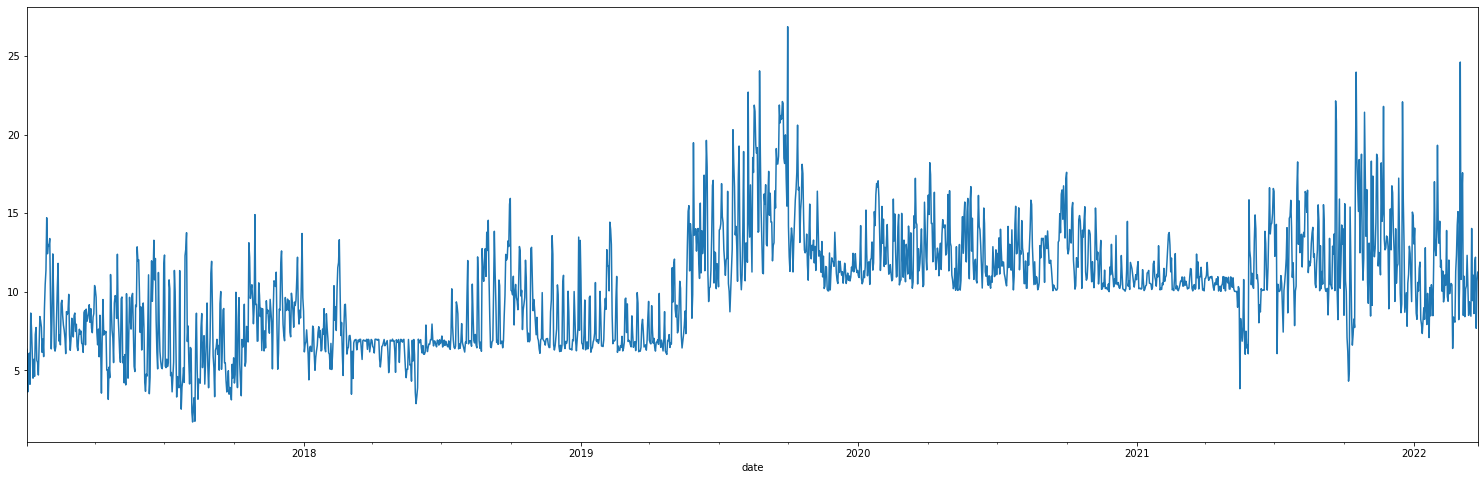

In [5]:
raw_data_tmp['op_reserve_ratio'].plot(label='first_data', figsize=(26,8))

## FB Prophet

### 先預測尖峰供電

In [6]:
prophet_data = train[:]
prophet_data.rename(columns={first_forecast: 'y', 'date': 'ds'}, inplace=True)
prophet_data.reset_index(inplace=True)

In [7]:
model = Prophet(daily_seasonality=False, 
                yearly_seasonality=True, 
                weekly_seasonality=True,
                changepoint_range=0.55,
                seasonality_mode='additive')
for regressor in regressors_first:
    model.add_regressor(regressor)
model.fit(prophet_data)

Initial log joint probability = -16.0135


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5579.72   0.000103037       164.168      0.8062      0.8062      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5581.85   0.000739342       145.298           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     263       5582.31   3.65684e-05       155.797   2.311e-07       0.001      349  LS failed, Hessian reset 
     299       5582.54   0.000169864       111.701           1           1      390   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5582.85   7.75081e-05       90.0375           1           1      503   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     415       5582.88   1.60736e-05       108.966   1.846e-07       0.001      5

In [8]:
prophet_data.tail()

,index,ds,is_holiday,year,month,day,day_of_week,op_reserve,op_reserve_ratio,y
1890,1890,2022-03-07,0,2022,3,7,0,2527.0,8.50,29729.411765
1891,1891,2022-03-08,0,2022,3,8,1,3290.0,10.99,29936.305732
1892,1892,2022-03-09,0,2022,3,9,2,2550.0,8.42,30285.035629
1893,1893,2022-03-10,0,2022,3,10,3,3088.0,10.18,30333.988212
1894,1894,2022-03-11,0,2022,3,11,4,3148.0,10.37,30356.798457


In [9]:
future = test.rename(columns={'date': 'ds'})
# future.drop(['op_reserve'], axis = 1, inplace=True)
future.head()

,ds,is_holiday,year,month,day,day_of_week,op_reserve,op_reserve_ratio,peak_supply
1895,2022-03-12,2,2022,3,12,5,3438.0,12.32,27905.844156
1896,2022-03-13,2,2022,3,13,6,2839.0,10.36,27403.474903
1897,2022-03-14,0,2022,3,14,0,2659.0,8.50,31282.352941
1898,2022-03-15,0,2022,3,15,1,2986.0,9.37,31867.662753
1899,2022-03-16,0,2022,3,16,2,2859.0,8.94,31979.865772


In [10]:
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,day,...,year,year_lower,year_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-03-12,31982.885788,26168.091991,29253.817564,31982.885788,31982.885788,-4240.816650,-4240.816650,-4240.816650,5.575455,...,702.464256,702.464256,702.464256,-2688.333512,-2688.333512,-2688.333512,0.0,0.0,0.0,27742.069139
1,2022-03-13,31985.561576,25358.013267,28444.734325,31985.561576,31985.561576,-5156.944011,-5156.944011,-5156.944011,4.054366,...,702.464256,702.464256,702.464256,-2686.746346,-2686.746346,-2686.746346,0.0,0.0,0.0,26828.617565
2,2022-03-14,31988.237363,29746.818306,32897.972366,31988.237363,31988.237363,-706.325545,-706.325545,-706.325545,2.533276,...,702.464256,702.464256,702.464256,-2683.410595,-2683.410595,-2683.410595,0.0,0.0,0.0,31281.911818
3,2022-03-15,31990.913151,29899.792027,33094.712552,31990.913151,31990.913151,-436.361430,-436.361430,-436.361430,1.012187,...,702.464256,702.464256,702.464256,-2677.643639,-2677.643639,-2677.643639,0.0,0.0,0.0,31554.551721
4,2022-03-16,31993.588938,30033.163555,33327.901994,31993.588938,31993.588938,-413.419641,-413.419641,-413.419641,-0.508903,...,702.464256,702.464256,702.464256,-2668.855373,-2668.855373,-2668.855373,0.0,0.0,0.0,31580.169297


RMSE = 595.9370547869777


<AxesSubplot:xlabel='date'>

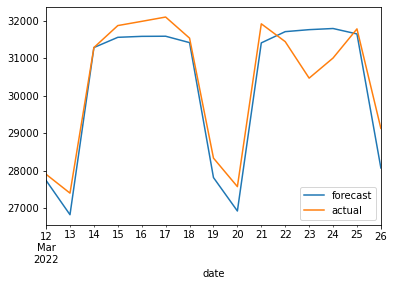

In [11]:
'''
整理結果 collate the results
'''
forecast_simplified = forecast[-n_tests:][['ds', 'yhat']]
forecast_simplified.columns = ['date', 'forecast']
# forecast_simplified['actual'] = raw_data['op_reserve'][-n_tests:].values
forecast_simplified['actual'] = raw_data[-n_tests:][first_forecast].values
'''
印出結果
'''
rmse = mean_squared_error(forecast_simplified['forecast'], forecast_simplified['actual'], squared=False)
print('RMSE =', rmse)
forecast_simplified.set_index('date',inplace=True)
forecast_simplified.plot(label='test_data')

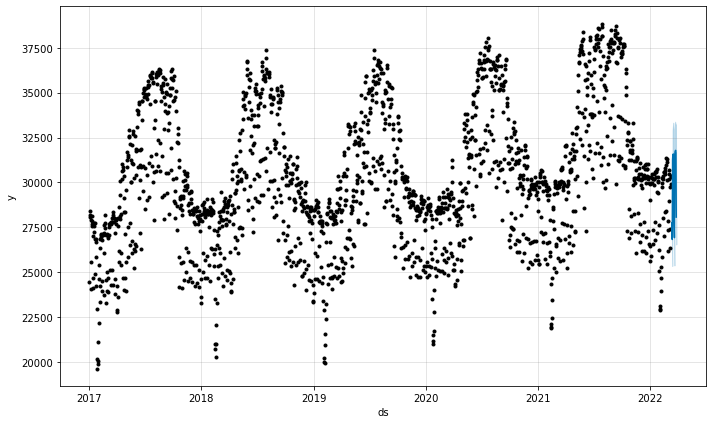

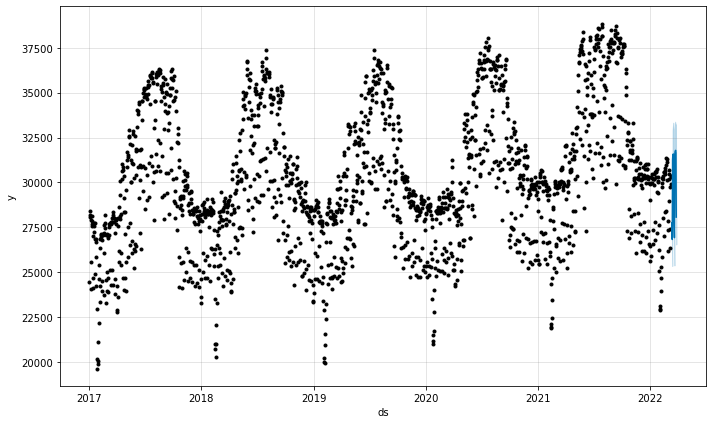

In [12]:
model.plot(forecast)

### 將預測結果代入

In [13]:
if first_forecast in dependencies:
    test[first_forecast] = forecast_simplified['forecast'].values

### 預測第二個值

In [14]:
'''
split training set and testing set
'''
train = raw_data[start_offset_second:-n_tests]
test = raw_data[-n_tests:]

In [15]:
prophet_data = train[:]
prophet_data.rename(columns={second_forecast: 'y', 'date': 'ds'}, inplace=True)
prophet_data.reset_index(inplace=True)

In [16]:
model = Prophet(daily_seasonality=False, 
                yearly_seasonality=True, 
                weekly_seasonality=False, 
                seasonality_mode='additive',
                changepoint_range=0.9,
                changepoint_prior_scale=100,
                seasonality_prior_scale=100)
for regressor in regressors_second:
    model.add_regressor(regressor)
model.fit(prophet_data)

Initial log joint probability = -18.49


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4118.56     0.0012581       187.107           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4172.29    0.00391627       144.669           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4194.58    0.00458205        324.88           1           1      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        4220.5     0.0137229       364.229      0.6824      0.6824      436   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        4237.9    0.00112858       64.4541           1           1      543   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

In [17]:
future = test.rename(columns={'date': 'ds'})
# future.drop(['op_reserve'], axis = 1, inplace=True)
future.head()

,ds,is_holiday,year,month,day,day_of_week,op_reserve,op_reserve_ratio,peak_supply
1895,2022-03-12,2,2022,3,12,5,3438.0,12.32,27742.069139
1896,2022-03-13,2,2022,3,13,6,2839.0,10.36,26828.617565
1897,2022-03-14,0,2022,3,14,0,2659.0,8.50,31281.911818
1898,2022-03-15,0,2022,3,15,1,2986.0,9.37,31554.551721
1899,2022-03-16,0,2022,3,16,2,2859.0,8.94,31580.169297


In [18]:
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,day,...,year,year_lower,year_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-03-12,-8.834473,8.696478,13.238908,-8.834473,-8.834473,19.761209,19.761209,19.761209,-0.164794,...,25.163039,25.163039,25.163039,-3.550371,-3.550371,-3.550371,0.0,0.0,0.0,10.926735
1,2022-03-13,-8.856309,9.882465,14.082684,-8.856309,-8.856309,20.739672,20.739672,20.739672,-0.119835,...,25.163039,25.163039,25.163039,-3.513698,-3.513698,-3.513698,0.0,0.0,0.0,11.883363
2,2022-03-14,-8.878145,7.699039,12.104904,-8.878145,-8.878145,18.729163,18.729163,18.729163,-0.074876,...,25.163039,25.163039,25.163039,-3.476762,-3.476762,-3.476762,0.0,0.0,0.0,9.851017
3,2022-03-15,-8.899981,7.338543,11.863693,-8.899981,-8.899981,18.542979,18.542979,18.542979,-0.029917,...,25.163039,25.163039,25.163039,-3.440225,-3.440225,-3.440225,0.0,0.0,0.0,9.642998
4,2022-03-16,-8.921817,7.549369,11.878819,-8.921817,-8.921817,18.598282,18.598282,18.598282,0.015042,...,25.163039,25.163039,25.163039,-3.404730,-3.404730,-3.404730,0.0,0.0,0.0,9.676464


RMSE = 1.761063198150491


<AxesSubplot:xlabel='date'>

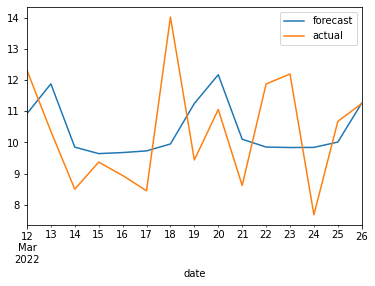

In [19]:
'''
整理結果 collate the results
'''
forecast_simplified = forecast[-n_tests:][['ds', 'yhat']]
forecast_simplified.columns = ['date', 'forecast']
# forecast_simplified['actual'] = raw_data['op_reserve'][-n_tests:].values
forecast_simplified['actual'] = raw_data[-n_tests:][second_forecast].values
'''
印出結果
'''
rmse = mean_squared_error(forecast_simplified['forecast'], forecast_simplified['actual'], squared=False)
print('RMSE =', rmse)
forecast_simplified.set_index('date',inplace=True)
forecast_simplified.plot(label='test_data')

In [20]:
if second_forecast in dependencies:
    test[second_forecast] = forecast_simplified['forecast'].values

### 接著預測備轉容量

In [21]:
'''
split training set and testing set
'''
train = raw_data[start_offset_final:-n_tests]
test = raw_data[-n_tests:]

In [22]:
prophet_data = train[:]
prophet_data.rename(columns={'op_reserve': 'y', 'date': 'ds'}, inplace=True)
prophet_data.reset_index(inplace=True)

In [23]:
model = Prophet(daily_seasonality=False, 
                yearly_seasonality=False, 
                weekly_seasonality=False, 
                seasonality_mode='additive',
                changepoint_range=0.95,
                changepoint_prior_scale=100,
                seasonality_prior_scale=100
                )
for regressor in regressors_op_reserve:
    model.add_regressor(regressor)
model.fit(prophet_data)

Initial log joint probability = -23.7124
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6957.29     0.0122324       6216.36           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7090.11    0.00568865       3388.51           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7178.69   0.000668958       640.128           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7201.57      0.019204       5019.28           1           1      444   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7226.36    0.00158343       629.578           1           1      551   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [24]:
future = test.rename(columns={'date': 'ds'})
future.head()

,ds,is_holiday,year,month,day,day_of_week,op_reserve,op_reserve_ratio,peak_supply
1895,2022-03-12,2,2022,3,12,5,3438.0,10.926735,27742.069139
1896,2022-03-13,2,2022,3,13,6,2839.0,11.883363,26828.617565
1897,2022-03-14,0,2022,3,14,0,2659.0,9.851017,31281.911818
1898,2022-03-15,0,2022,3,15,1,2986.0,9.642998,31554.551721
1899,2022-03-16,0,2022,3,16,2,2859.0,9.676464,31580.169297


In [25]:
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,day_of_week,...,op_reserve_ratio,op_reserve_ratio_lower,op_reserve_ratio_upper,peak_supply,peak_supply_lower,peak_supply_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-03-12,3031.705207,2845.966328,3108.340229,3031.705207,3031.705207,-56.271579,-56.271579,-56.271579,6.617353,...,221.921238,221.921238,221.921238,-242.414665,-242.414665,-242.414665,0.0,0.0,0.0,2975.433628
1,2022-03-13,3031.902274,3056.887109,3302.273140,3031.902274,3031.902274,147.537803,147.537803,147.537803,9.921671,...,511.645703,511.645703,511.645703,-331.634066,-331.634066,-331.634066,0.0,0.0,0.0,3179.440077
2,2022-03-14,3032.099341,2918.095876,3174.745757,3032.099341,3032.099341,3.949436,3.949436,3.949436,-9.904234,...,-103.871052,-103.871052,-103.871052,103.331786,103.331786,103.331786,0.0,0.0,0.0,3036.048777
3,2022-03-15,3032.296408,2881.012160,3140.047346,3032.296408,3032.296408,-29.117627,-29.117627,-29.117627,-6.599916,...,-166.871943,-166.871943,-166.871943,129.961297,129.961297,129.961297,0.0,0.0,0.0,3003.178782
4,2022-03-16,3032.493476,2889.887392,3142.385775,3032.493476,3032.493476,-13.175441,-13.175441,-13.175441,-3.295599,...,-156.736216,-156.736216,-156.736216,132.463438,132.463438,132.463438,0.0,0.0,0.0,3019.318035


RMSE = 526.6548873847955


,forecast,actual
date,,
2022-03-12,2975.433628,3438.0
2022-03-13,3179.440077,2839.0
2022-03-14,3036.048777,2659.0
2022-03-15,3003.178782,2986.0
2022-03-16,3019.318035,2859.0


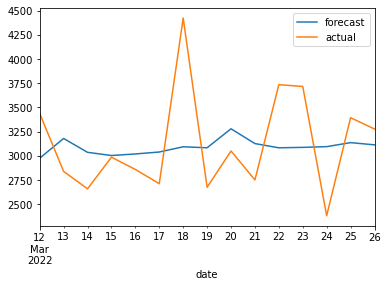

In [26]:
'''
整理結果 collate the results
'''
forecast_simplified = forecast[-n_tests:][['ds', 'yhat']]
forecast_simplified.columns = ['date', 'forecast']
# forecast_simplified['actual'] = raw_data['op_reserve'][-n_tests:].values
forecast_simplified['actual'] = raw_data[-n_tests:]['op_reserve'].values
'''
印出結果
'''
rmse = mean_squared_error(forecast_simplified['forecast'], forecast_simplified['actual'], squared=False)
print('RMSE =', rmse)
forecast_simplified.set_index('date',inplace=True)
forecast_simplified.plot(label='test_data')
forecast_simplified.head()

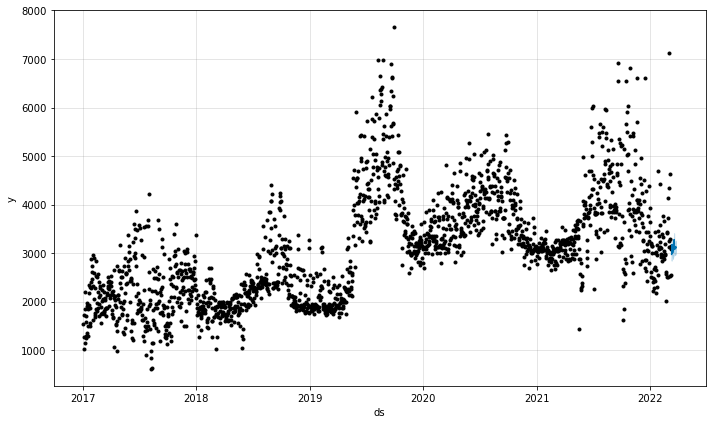

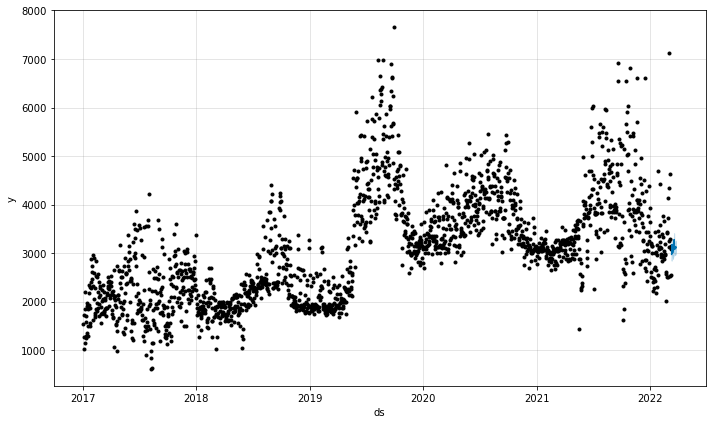

In [27]:
model.plot(forecast)

### 或是直接將兩者乘起來

RMSE = 523.339138543489


<AxesSubplot:>

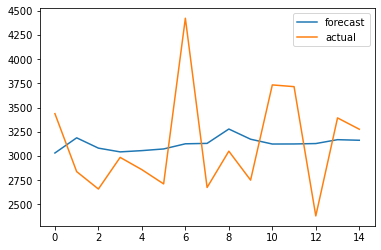

In [28]:
forecast_final= test[-n_tests:][['date', 'op_reserve_ratio', 'peak_supply', 'op_reserve']]
forecast_final.reset_index(drop=True, inplace=True)
forecast_simplified.head()
for i, item in enumerate(forecast_final['op_reserve']):
    forecast_final['op_reserve'][i] = forecast_final['peak_supply'][i] * forecast_final['op_reserve_ratio'][i] / 100
forecast_final['actual'] = raw_data[-n_tests:]['op_reserve'].values
forecast_final.rename(columns={'op_reserve': 'forecast'}, inplace=True)
forecast_final = forecast_final.loc[:,['forecast', 'actual']]
'''
印出結果
'''
rmse = mean_squared_error(forecast_final['forecast'], forecast_final['actual'], squared=False)
print('RMSE =', rmse)
forecast_final.plot(label='test_data')

In [29]:
forecast_final.head()

,forecast,actual
0,3031.302491,3438.0
1,3188.141990,2839.0
2,3081.586531,2659.0
3,3042.804663,2986.0
4,3055.843799,2859.0


## Master Cell: Test Different Parameters
`start_offset_first`
`start_offset_second`
`multistep`